# Heart Disease Prediction

## Importing Dataset and Packages

In [1]:
#Importing packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from tensorflow import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

In [2]:
#Importing dataset.
df = pd.read_csv("heart.csv")
raw_df = df.copy() #Its better to always have a copy.(just in case I need the original dataset)

## EDA

In [3]:
#Lets take a quick look at the dataset.
df.sample(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
166,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1
282,51,F,NAP,130,220,0,Normal,160,Y,2.0,Up,0
74,55,M,ASY,140,268,0,Normal,128,Y,1.5,Flat,1


In [4]:
#Do we have missing values in dataset?
df.isnull().mean() * 100

NumExpr defaulting to 8 threads.


Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

There is no need for imputer.(No missing values)

In [5]:
#Before starting anything lets see how balanced our dataset is?
df.HeartDisease.value_counts(normalize=True) * 100

1    55.337691
0    44.662309
Name: HeartDisease, dtype: float64

In [6]:
#Which columns have categorical values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The dataset seams balanced enough so we wont perform any type of up or down sampling.

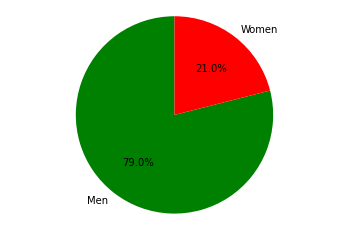

In [7]:
#First thing that comes to mind is that how many of the people in this dataset are men and how many are women?
men = list(df["Sex"]).count("M") #Number of men in dataset.
women = list(df["Sex"]).count("F") #Number of women in dataset.
plt.pie([men,women],
        labels=["Men","Women"],
        colors=["green","red"],
        startangle=90,
        autopct='%1.1f%%')
plt.axis('equal')
plt.show()

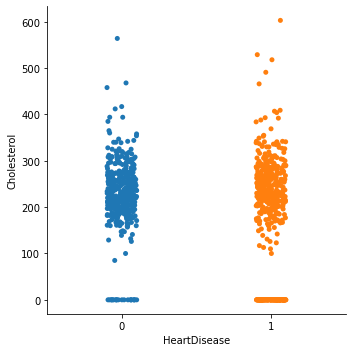

In [8]:
#How much does cholestrol effect heart disease?
sns.catplot(x="HeartDisease", y="Cholesterol", data=df)

It seems that "Cholesterol" by itself is not a factor for HeartDisease! (I personally thought different)

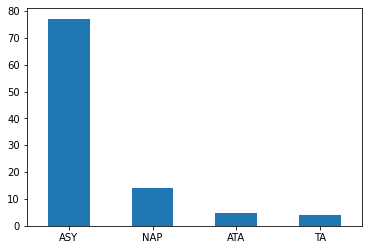

In [9]:
#What type of chest pain is most common between people with heart disease?
#Only people with heart disease not healthy people.
ill_people =df.query('HeartDisease == 1') 
ill_people_type_percentage = pd.Series(ill_people.ChestPainType.value_counts(normalize=True) * 100,name="Percentage")
pd.DataFrame(ill_people_type_percentage)
ax = ill_people_type_percentage.plot.bar(x='Percentage', rot=0)

Wow! Almost 80% of people with heart disease have the same chest pain type.

So it seems theres a big correlation between this chest pain type and heart disease.

But since I dont have any domain expertise I will decide on features based on statistics.

Text(0.5, 1.0, 'Correlation ')

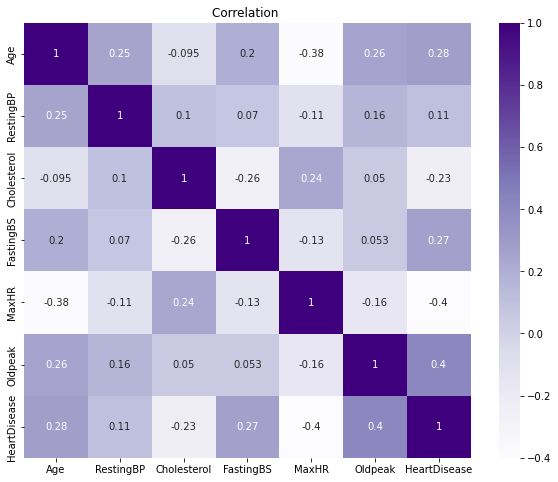

In [10]:
corr=df.corr()
fig = plt.figure(figsize=(10,8))
r = sns.heatmap(corr, cmap='Purples' , annot=True)
r.set_title("Correlation ")

In [11]:
#Sorting the continous values of the dataset correlation based on HeartDisease.
corr.sort_values(by=["HeartDisease"],ascending=False).iloc[0].sort_values(ascending=False)

HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64

Up until know theres no evidence supporting the idea of removing some features.

## Pre-Processing

In [12]:
from sklearn.model_selection import train_test_split
X = df.drop("HeartDisease",axis=1) #Selecting all columns except the labels.
y = df["HeartDisease"] #Selecting the labels.
#Spliting the dataset with stratified sampling.
X_train ,X_test, y_train ,y_test = train_test_split(X,y,test_size=0.15,random_state=7,stratify=y) 

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(780, 11)
(138, 11)
(780,)
(138,)


In [14]:
#Resetting index in X_train.
X_train = X_train.reset_index()
X_train.drop(["index"],axis=1,inplace=True)
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,49,F,ATA,124,201,0,Normal,164,N,0.0,Up
1,46,M,NAP,150,231,0,Normal,147,N,3.6,Flat
2,65,M,ASY,110,248,0,LVH,158,N,0.6,Up
3,47,M,ASY,110,275,0,LVH,118,Y,1.0,Flat
4,44,F,NAP,118,242,0,Normal,149,N,0.3,Flat
...,...,...,...,...,...,...,...,...,...,...,...
775,68,M,NAP,134,254,1,Normal,151,Y,0.0,Up
776,61,M,ASY,150,0,0,Normal,117,Y,2.0,Flat
777,49,M,TA,130,0,0,ST,145,N,3.0,Flat
778,50,M,ATA,170,209,0,ST,116,N,0.0,Up


In [15]:
#Resetting index in X_test.
X_test = X_test.reset_index()
X_test.drop(["index"],axis=1,inplace=True)

In [16]:
#Selecting all columns with numeric values in X_train.
X_train_numeric = X_train.select_dtypes(include=np.number)
X_train_numeric

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,49,124,201,0,164,0.0
1,46,150,231,0,147,3.6
2,65,110,248,0,158,0.6
3,47,110,275,0,118,1.0
4,44,118,242,0,149,0.3
...,...,...,...,...,...,...
775,68,134,254,1,151,0.0
776,61,150,0,0,117,2.0
777,49,130,0,0,145,3.0
778,50,170,209,0,116,0.0


In [17]:
#Selecting all columns with non-numeric values in X_train.
X_train_non_numeric =X_train.select_dtypes(exclude=np.number)
X_train_non_numeric

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,F,ATA,Normal,N,Up
1,M,NAP,Normal,N,Flat
2,M,ASY,LVH,N,Up
3,M,ASY,LVH,Y,Flat
4,F,NAP,Normal,N,Flat
...,...,...,...,...,...
775,M,NAP,Normal,Y,Up
776,M,ASY,Normal,Y,Flat
777,M,TA,ST,N,Flat
778,M,ATA,ST,N,Up


Before scaling the data I want to see the correlations and use variance threshold.

Then we will perform feature selection.

In [18]:
selector = VarianceThreshold(threshold=0.3) #Creating object.
selector.fit(X_train_numeric)
selector.get_feature_names_out() #Checking if there is any column the selector wants to remove.

array(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'],
      dtype=object)

The selector has not selected any feature for deletion.

So we are gonna use correlation matrix.

In [19]:
#Since I want to train a NN its better to use normalization for feature scaling.
mms = MinMaxScaler()
X_train_numeric = pd.DataFrame(mms.fit_transform(X_train_numeric),columns = X_train_numeric.columns)
X_train_numeric

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,0.428571,0.366667,0.356383,0.0,0.732394,0.295455
1,0.367347,0.583333,0.409574,0.0,0.612676,0.704545
2,0.755102,0.250000,0.439716,0.0,0.690141,0.363636
3,0.387755,0.250000,0.487589,0.0,0.408451,0.409091
4,0.326531,0.316667,0.429078,0.0,0.626761,0.329545
...,...,...,...,...,...,...
775,0.816327,0.450000,0.450355,1.0,0.640845,0.295455
776,0.673469,0.583333,0.000000,0.0,0.401408,0.522727
777,0.428571,0.416667,0.000000,0.0,0.598592,0.636364
778,0.448980,0.750000,0.370567,0.0,0.394366,0.295455


In [20]:
#One hot encoding categorical features.
X_train_non_numeric = pd.get_dummies(X_train_non_numeric)
X_train_non_numeric

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,0,1,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1,1,0,0,0,1,0,0,1,0,0,0,1
3,0,1,1,0,0,0,1,0,0,0,1,0,1,0
4,1,0,0,0,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0,1,0,0,1,0,0,1,0,0,1,0,0,1
776,0,1,1,0,0,0,0,1,0,0,1,0,1,0
777,0,1,0,0,0,1,0,0,1,1,0,0,1,0
778,0,1,0,1,0,0,0,0,1,1,0,0,0,1


In [21]:
#Double checking the dimensions of the different dataframes for concatenating.
#Since we have resetted the indexes the will be no problem.
print(X_train_numeric.shape)
print(X_train_non_numeric.shape)

(780, 6)
(780, 14)


In [22]:
#Concatenating two parts of X_train.
X_train = pd.concat([X_train_numeric,X_train_non_numeric],axis=1)
X_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.428571,0.366667,0.356383,0.0,0.732394,0.295455,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,0.367347,0.583333,0.409574,0.0,0.612676,0.704545,0,1,0,0,1,0,0,1,0,1,0,0,1,0
2,0.755102,0.250000,0.439716,0.0,0.690141,0.363636,0,1,1,0,0,0,1,0,0,1,0,0,0,1
3,0.387755,0.250000,0.487589,0.0,0.408451,0.409091,0,1,1,0,0,0,1,0,0,0,1,0,1,0
4,0.326531,0.316667,0.429078,0.0,0.626761,0.329545,1,0,0,0,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.816327,0.450000,0.450355,1.0,0.640845,0.295455,0,1,0,0,1,0,0,1,0,0,1,0,0,1
776,0.673469,0.583333,0.000000,0.0,0.401408,0.522727,0,1,1,0,0,0,0,1,0,0,1,0,1,0
777,0.428571,0.416667,0.000000,0.0,0.598592,0.636364,0,1,0,0,0,1,0,0,1,1,0,0,1,0
778,0.448980,0.750000,0.370567,0.0,0.394366,0.295455,0,1,0,1,0,0,0,0,1,1,0,0,0,1


In [23]:
#We need to apply all the steps for the X_test dataframe as well.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(780, 20)
(138, 11)
(780,)
(138,)


In [24]:
#Seperating two parts of dataframe for feature scaling and one hot encoding.
X_test_numeric = X_test.select_dtypes(include=np.number)
X_test_non_numeric =X_test.select_dtypes(exclude=np.number)
#Applying feature scaling.
X_test_numeric = pd.DataFrame(mms.transform(X_test_numeric),columns = X_test_numeric.columns)
#Applying one hot encoding.
X_test_non_numeric = pd.get_dummies(X_test_non_numeric)
#Concatenating two seperated parts of dataframe.
X_test = pd.concat([X_test_numeric,X_test_non_numeric],axis=1)
X_test

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.591837,0.583333,0.223404,1.0,0.795775,0.318182,0,1,0,0,1,0,0,1,0,1,0,0,0,1
1,0.408163,0.333333,0.313830,1.0,0.619718,0.295455,1,0,0,1,0,0,0,0,1,1,0,0,0,1
2,0.714286,0.583333,0.000000,0.0,0.183099,0.522727,0,1,1,0,0,0,0,1,0,0,1,0,1,0
3,0.714286,0.500000,0.345745,0.0,0.838028,0.295455,1,0,0,1,0,0,0,1,0,1,0,0,0,1
4,0.448980,0.333333,0.297872,0.0,0.704225,0.295455,0,1,0,1,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.693878,0.666667,0.000000,0.0,0.084507,0.295455,0,1,0,0,1,0,0,1,0,0,1,0,1,0
134,0.755102,0.666667,0.638298,0.0,0.640845,0.386364,1,0,0,0,1,0,1,0,0,1,0,0,0,1
135,0.346939,0.250000,0.000000,0.0,0.549296,0.284091,0,1,0,0,1,0,0,1,0,1,0,0,0,1
136,0.367347,0.291667,0.000000,0.0,0.373239,0.465909,0,1,1,0,0,0,0,1,0,0,1,0,1,0


In [25]:
#Since we seperated our data from the beginning there will be no data leakage
#or sampling bias and we can count on our models for deployment.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(780, 20)
(138, 20)
(780,)
(138,)


## Training models

For creating our models its better to perform grid search with k-fold cross validation.

Since we are predicting a disease its better to use recall than accuracy.

### Random Forest

In [26]:
randomforest_model = RandomForestClassifier() #Creating RandomForestClassifier object for grid search.

parameters_randomforest = [{"n_estimators": range(10,130,2),
               "max_depth" : range(5,20,5)}] #Selecting which hyperparameters on what ranges the grid search must search on.

grid_search_randomforest = GridSearchCV(estimator = randomforest_model,
                           param_grid = parameters_randomforest,
                           scoring = 'recall',
                           cv = 10, #Using 10 k-folds.
                           n_jobs = -1) #Using all cpu cores.

grid_search_randomforest.fit(X_train, y_train) #Performing the grid search.
best_rf = grid_search_randomforest.best_estimator_
best_recall_randomforest = grid_search_randomforest.best_score_
print("Best Recall: {:.2f} %".format(best_recall_randomforest*100))

Best Recall: 92.57 %


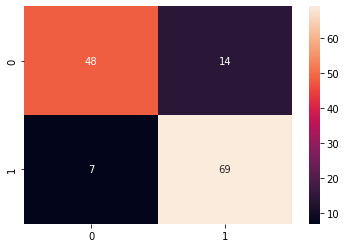

In [27]:
#Confusion matrix for RandomForest model.
y_pred_rf = best_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True)
plt.show()

### SVC

In [28]:
svc_model = SVC(kernel = 'rbf', random_state = 17) #Creating the svc object for grid search.

#Selecting which hyperparameters on what ranges the grid search must search on.
parameters_svc = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
                  {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                  {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['poly'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search_svc = GridSearchCV(estimator = svc_model,
                           param_grid = parameters_svc,
                           scoring = 'recall',
                           cv = 10, #Using 10 k-folds.
                           n_jobs = -1) #Using all cpu cores.

grid_search_svc.fit(X_train, y_train) #Perfroming the grid search.
best_svc = grid_search_svc.best_estimator_
best_recall_svc = grid_search_svc.best_score_
print("Best Recall: {:.2f} %".format(best_recall_svc*100))

Best Recall: 91.19 %


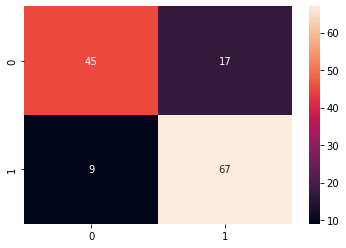

In [29]:
#Confusion matrix for SVC model.
y_pred_svc = best_svc.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True)
plt.show()

### KNN

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=5) #Creating a KNN object for grid search.

#Selecting the range of the given hyperparameter to search on.
parameters_knn = [{"n_neighbors" : range(3,8)}]

grid_search_knn = GridSearchCV(estimator = knn_model,
                           param_grid = parameters_knn,
                           scoring = 'recall',
                           cv = 10, #Using 10 k-folds.
                           n_jobs = -1) #Using all cpu cores.

grid_search_knn.fit(X_train,y_train) #Performing the grid search.
best_knn = grid_search_knn.best_estimator_
best_recall_knn = grid_search_knn.best_score_
print("Best Recall: {:.2f} %".format(best_recall_knn*100))

Best Recall: 89.80 %


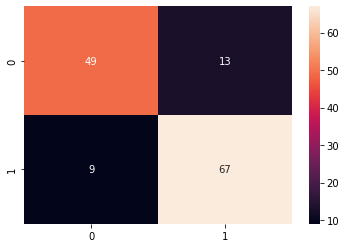

In [31]:
#Confusion matrix for SVC model.
y_pred_knn = best_knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True)
plt.show()

### Neural Network

Since there is not enough training data in the dataset the NN wont perform as good as the others.(Just a guess)

We make a shallow network and then check the confusion matrix.

In [32]:
#Making a shallow sequential model.
nn = models.Sequential()
nn.add(layers.Flatten())
nn.add(layers.Dense(3,activation='selu',kernel_regularizer=regularizers.l1(0.01)))
nn.add(layers.Dense(2,activation='selu',kernel_regularizer=regularizers.l1(0.01)))
nn.add(layers.Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l1(0.01)))

2022-01-27 20:28:47.111313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
#Compiling the model.
nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999), #Using adam optimizer.
           loss='binary_crossentropy',
           metrics=[tf.keras.metrics.Recall()]) #Instead of accuracy we use recall.

In [34]:
#Training the model.
history = nn.fit(X_train,y_train,
                 epochs=300, #Since we dont have enough training data we use high epoch count.
                 batch_size=32,
                 validation_split=0.2, #We use cross validation for training.
                 verbose=0)

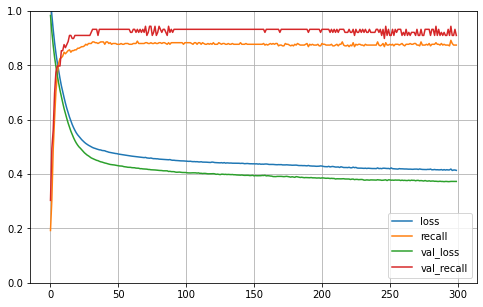

In [35]:
#Plotting the results.
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

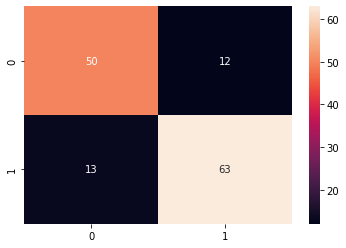

Recall score :  0.8289473684210527


In [36]:
#Confusion matrix for NN.
y_pred_nn = nn.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5)
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True)
plt.show()
print("Recall score : ",recall_score(y_test, y_pred_nn)) #Print Recall score of the NN.

Up until now the RandomForestClassifier was the best model.

Now its time to make an ensemble model with softvoting classifiers.

If the ensemble works better than the random forest it will get deployed.

### Ensemble SoftVote Model

In [37]:
#Making a SoftVote classifier.
voting_clf = VotingClassifier(
    estimators=[('knn', best_knn), ('rf', best_rf), ('svc', best_svc)],
    voting='hard') #Using SoftVoting.

voting_clf.fit(X_train, y_train) #Training the classifier.

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=46)),
                             ('svc', SVC(C=0.25, gamma=0.9, random_state=17))])

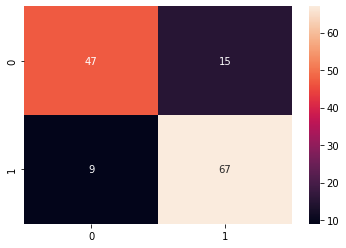

Recall score :  0.881578947368421


In [38]:
#Confusion matrix for ensemble model.
y_pred_voting_clf = voting_clf.predict(X_test)
y_pred_voting_clf = (y_pred_voting_clf > 0.5)
cm_voting_clf = confusion_matrix(y_test, y_pred_voting_clf)
sns.heatmap(cm_voting_clf, annot=True)
plt.show()
print("Recall score : ",recall_score(y_test, y_pred_voting_clf))

It seems that even with ensemble classifier we cant get a good enough recall score.

So we are gonna use the RandomForestClassifier.